In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.linear_model import LinearRegression

def lowess(x, y, f=1./3.):
    """
    Basic LOWESS smoother with uncertainty. 
    Note:
        - Not robust (so no iteration) and
             only normally distributed errors. 
        - No higher order polynomials d=1 
            so linear smoother.
    """
    # get some paras
    xwidth = f*(x.max()-x.min()) # effective width after reduction factor
    N = len(x) # number of obs
    # Don't assume the data is sorted
    order = np.argsort(x)
    # storage
    y_sm = np.zeros_like(y)
    y_stderr = np.zeros_like(y)
    # define the weigthing function -- clipping too!
    tricube = lambda d : np.clip((1- np.abs(d)**3)**3, 0, 1)
    # run the regression for each observation i
    for i in range(N):
        dist = np.abs((x[order][i]-x[order]))/xwidth
        w = tricube(dist)
        # form linear system with the weights
        A = np.stack([w, x[order]*w]).T
        b = w * y[order]
        ATA = A.T.dot(A)
        ATb = A.T.dot(b)
        # solve the syste
        sol = np.linalg.solve(ATA, ATb)
        # predict for the observation only
        yest = A[i].dot(sol)# equiv of A.dot(yest) just for k
        place = order[i]
        y_sm[place]=yest 
        sigma2 = (np.sum((A.dot(sol) -y [order])**2)/N )
        # Calculate the standard error
        y_stderr[place] = np.sqrt(sigma2 * 
                                A[i].dot(np.linalg.inv(ATA)
                                                    ).dot(A[i]))
    return y_sm, y_stderr


def logit(x, c, eps=1e-2):
    x2 = (x-c)/(1-c)
    return np.log((x2+eps)/(1-x2+eps)), c

def sigmoid(x):
    return 1/(1+np.exp(-x))
    
num_fam = 10
start = 0

In [3]:
scenarios = ['IFEval','BBH','MATH Lvl 5','GPQA','MUSR','MMLU-PRO','MMLU','ARC','HellaSwag','Winogrande','TruthfulQA','GSM8K']

In [4]:
lower_bounds = {}
for s in scenarios:
    lower_bounds[s]=pd.read_csv('data/lower_bounds.csv')[s].iloc[0]

(188, 119)


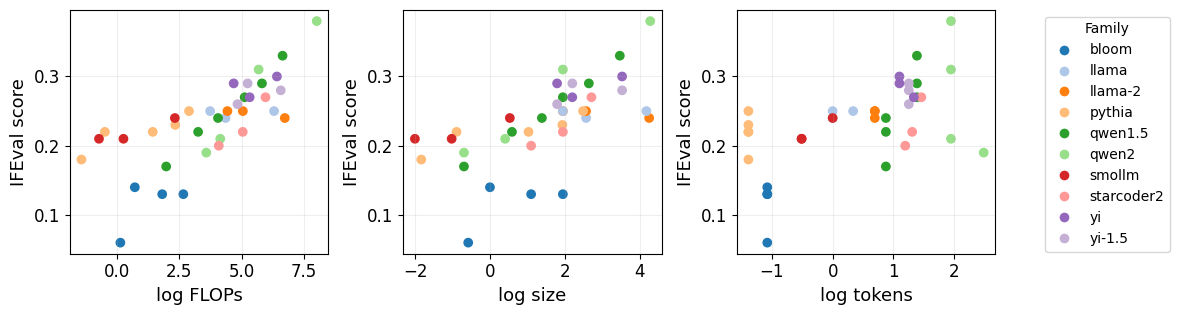

(188, 119)


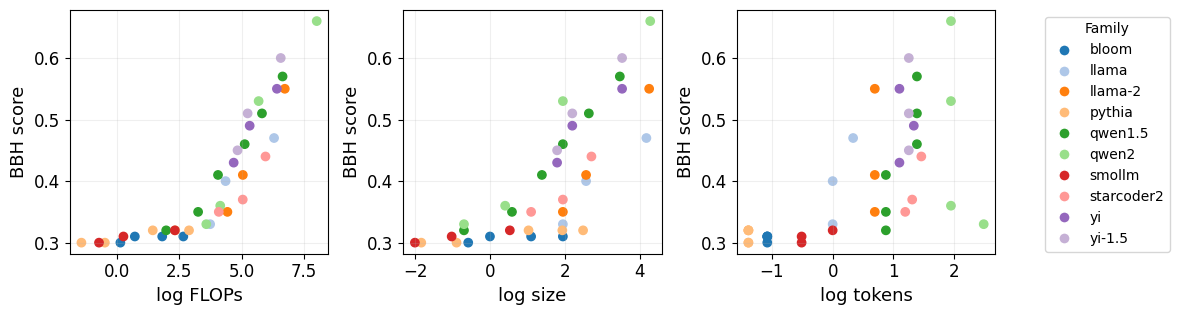

(188, 119)


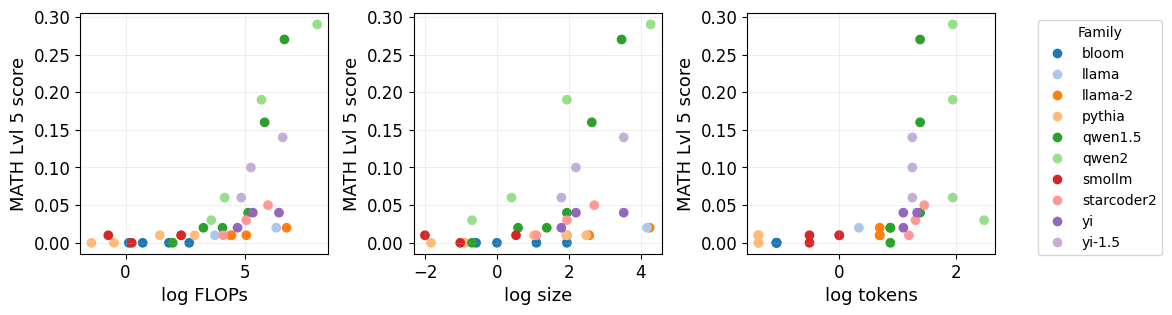

(188, 119)


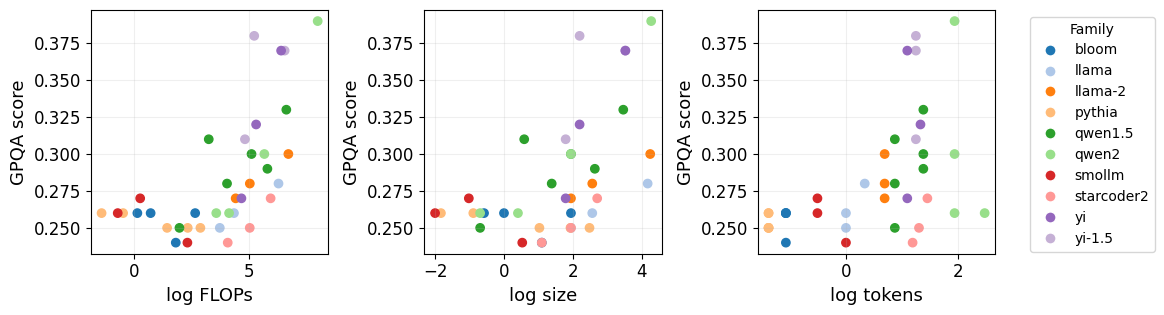

(188, 119)


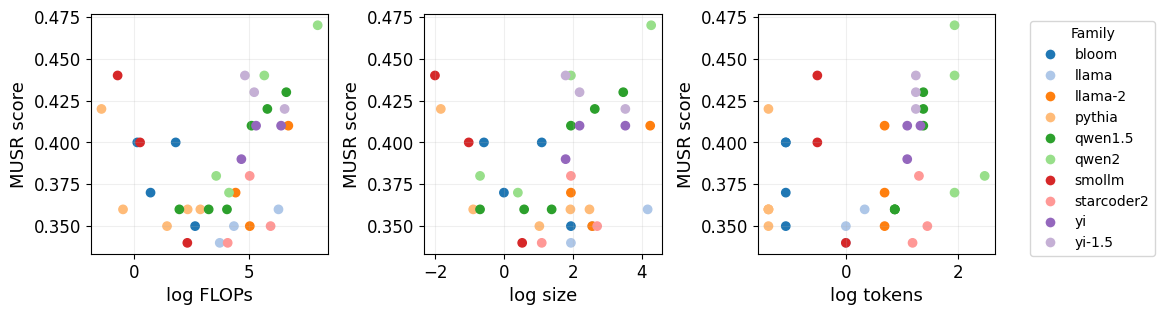

(188, 119)


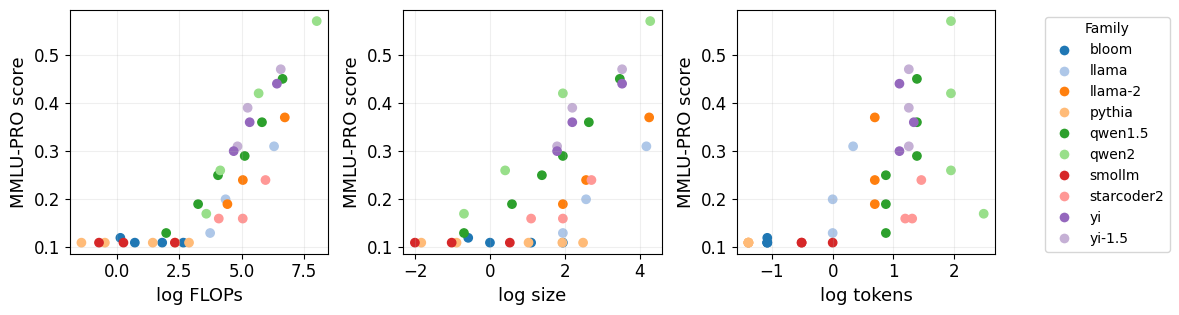

(188, 119)


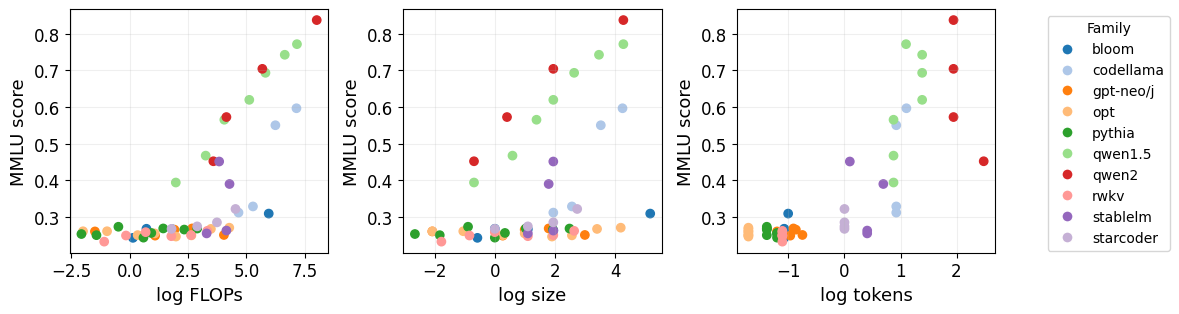

(188, 119)


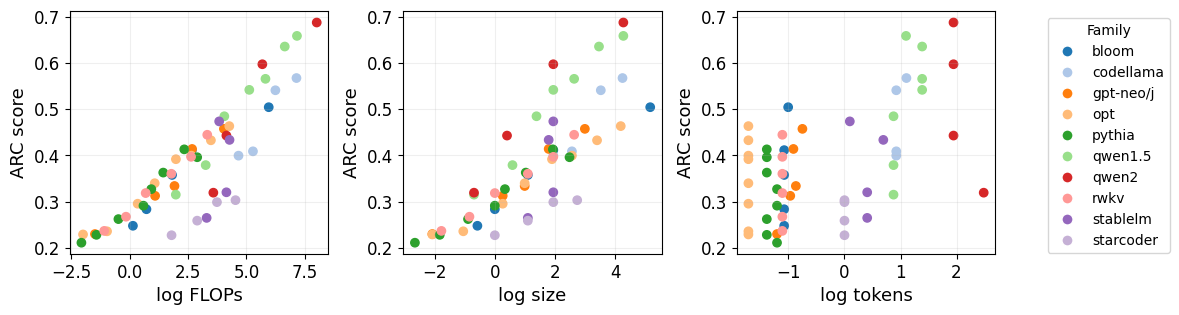

(188, 119)


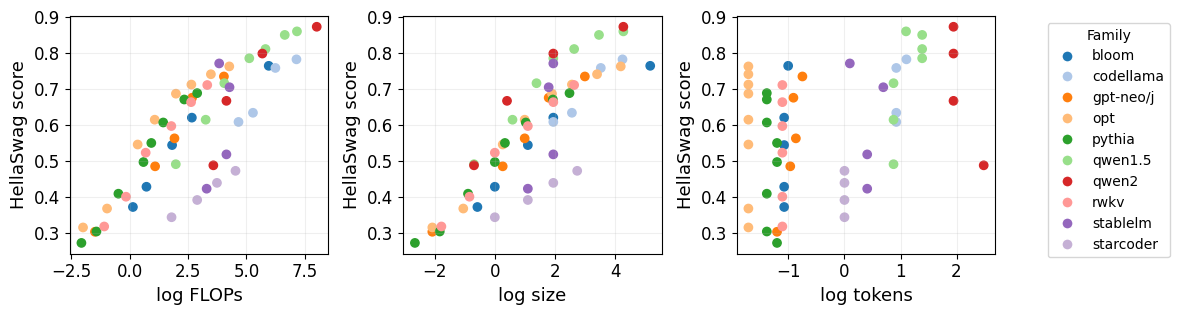

(188, 119)


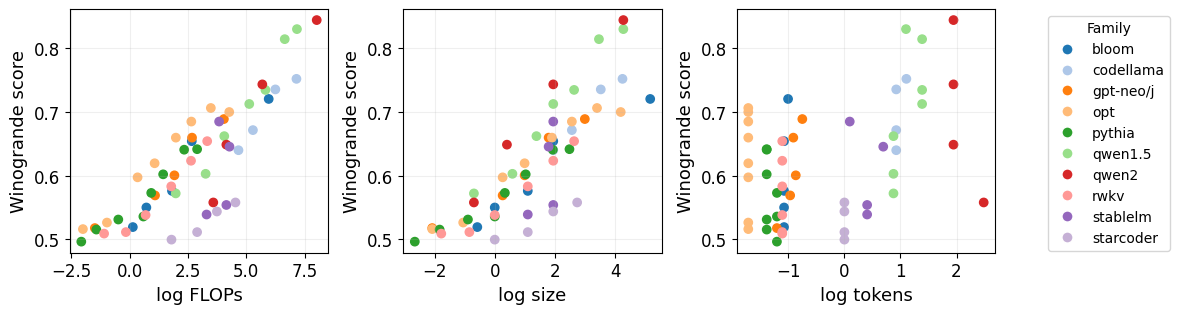

(188, 119)


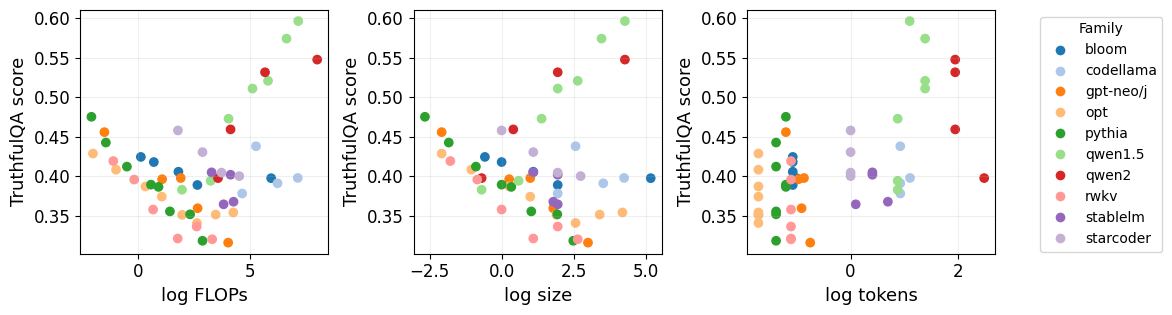

(188, 119)


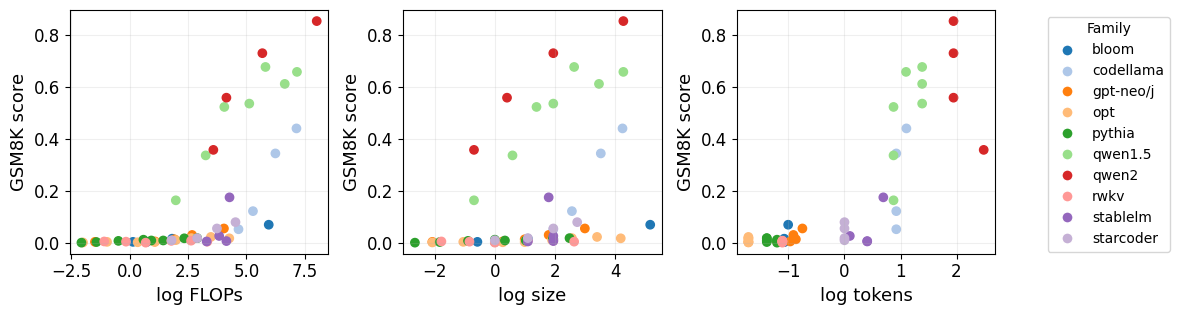

In [44]:
for scenario in scenarios:
    data = pd.read_csv('data/data_v2.csv')
    print(data.shape)
    data['logS'] = np.log(data['#Params (B)'])
    data['logT'] = np.log(data['Pretraining Data Size (T)'])
    data['logF'] = np.log(data['FLOPs (1E21)'])
    data = data.loc[~data.Instruct,['Model','Family','Instruct','logS','logT','logF']+[scenario]]
    data = data.dropna()
    #print(data.Family.value_counts().iloc[start:start+num_fam])
    selected_families = list(data.Family.value_counts().iloc[start:start+num_fam].index)
    data = data.loc[[m in selected_families for m in data.Family]]
    #print(data.shape)

    y = np.array(data[scenario])
    logS = np.array(data['logS'])
    logT = np.array(data['logT'])
    logF = np.array(data['logF'])
    Fam = np.array(data.Family)
    unique_categories = np.unique(Fam)
    color_map = {category: color for category, color in zip(unique_categories, plt.cm.tab20.colors)}
    colors = [color_map[category] for category in Fam]
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.25))
    
    # First plot
    sc1 = axs[0].scatter(logF, y, c=colors)
    axs[0].set_xlabel('log FLOPs', size=13)
    axs[0].set_ylabel(f'{scenario} score', size=13)
    
    # Second plot
    sc2 = axs[1].scatter(logS, y, c=colors)
    axs[1].set_xlabel('log size', size=13)
    axs[1].set_ylabel(f'{scenario} score', size=13)
    
    # Third plot
    sc3 = axs[2].scatter(logT, y, c=colors)
    axs[2].set_xlabel('log tokens', size=13)
    axs[2].set_ylabel(f'{scenario} score', size=13)
    
    # Adding a legend for the family colors
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[fam], markersize=8, label=f'{fam}')
               for fam in unique_categories]
    axs[2].legend(handles=handles, title='Family', loc='upper right', bbox_to_anchor=(1.7, 1))
    
    # Set other properties
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust 'labelsize' as needed
        ax.grid(alpha=.2)
    
    # Adjust layout and save
    plt.tight_layout()
    plt.savefig(f'plots/{scenario}.png')
    plt.show()


In [ ]:
 y = np.array(data[scenario])
    logS = np.array(data['logS'])
    logT = np.array(data['logT'])
    logF = np.array(data['logF'])
    Fam = np.array(data.Family)
    unique_categories = np.unique(Fam)
    color_map = {category: color for category, color in zip(unique_categories, plt.cm.tab20.colors)}
    colors = [color_map[category] for category in Fam]
    
    fig, axs = plt.subplots(1, 3, figsize=(12, 3.5))
    sc1 = axs[0].scatter(logF, y, c=colors)
    axs[0].set_xlabel('log FLOPs', size=13)
    axs[0].set_ylabel(f'{scenario} score', size=13)
    sc2 = axs[1].scatter(logS, y, c=colors)
    axs[1].set_xlabel('log size', size=13)
    axs[1].set_ylabel(f'{scenario} score', size=13)
    sc3 = axs[2].scatter(logT, y, c=colors)
    axs[2].set_xlabel('log tokens', size=13)
    axs[2].set_ylabel(f'{scenario} score', size=13)
    for fam in unique_categories:
        axs[2].scatter([], [], c=[color_map[fam]], label=f'{fam}')  # Replace 'Label' with actual label
    #axs[0].set_ylim(-3,)
    #axs[1].set_ylim(-3,)
    #axs[2].set_ylim(-3,)
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=12)  # Adjust 'labelsize' as needed
        ax.grid(alpha=.2)
    fig.legend(loc='upper right', bbox_to_anchor=(1.11, .875))
    #fig.suptitle(scenario)
    plt.tight_layout()
    #plt.subplots_adjust(wspace=0.4)  # You can increase or decrease the value of 'wspace'
    plt.savefig(f'plots/{scenario}.png')
    plt.show()

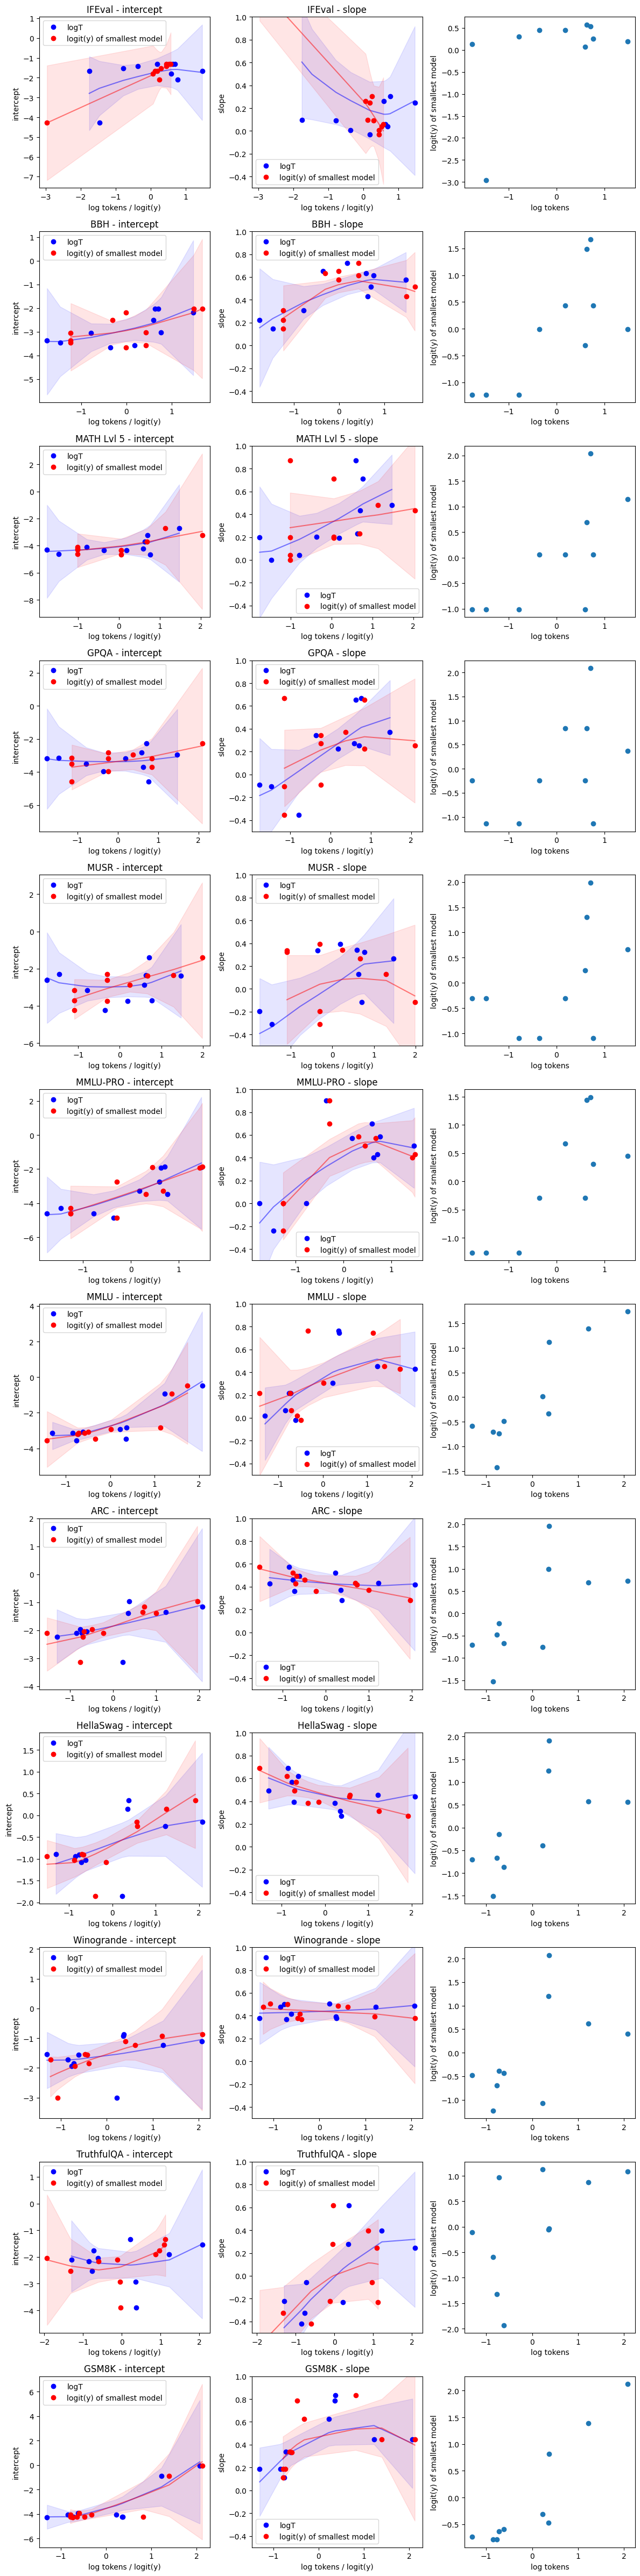

In [30]:
# Determine the number of rows needed (assuming 3 columns)
n_cols = 3
n_rows = (len(scenarios) * 3 + n_cols - 1) // n_cols  # 3 plots per scenario

fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, n_rows * 4))

for i, scenario in enumerate(scenarios):
    data = pd.read_csv('data/data_v1.csv')
    data['logS'] = np.log(data['#Params (B)'])
    data['logT'] = np.log(data['Pretraining Data Size (T)'])
    data['logF'] = np.log(data['FLOPs (1E21)'])
    data = data.loc[~data.Instruct, ['Model', 'Family', 'Instruct', 'logS', 'logT', 'logF'] + [scenario]]
    data = data.dropna()
    selected_families = list(data.Family.value_counts().iloc[start:start+num_fam].index)
    data = data.loc[[m in selected_families for m in data.Family]]
    
    y,c = logit(np.array(data[scenario]), c=lower_bounds[scenario])
    logS = np.array(data['logS'])
    logT = np.array(data['logT'])
    logF = np.array(data['logF'])
    Fam = np.array(data.Family)
    
    out = []
    for f in np.unique(Fam):
        ind = Fam == f
        reg = LinearRegression().fit(logS[ind][:, None], y[ind])
        out.append([y[ind].min(), logT[ind].mean(), reg.intercept_, reg.coef_[0]])
    out = np.array(out)
    
    y_labels = ['intercept', 'slope', 'logit(y) vs log tokens']

    for j, y_label in enumerate(y_labels):
        ax = axes[(3 * i + j) // n_cols, (3 * i + j) % n_cols]
        
        if y_label == 'logit(y) vs log tokens':
            x = (out[:, 1] - out[:, 1].mean()) / out[:, 1].std()
            ax.plot(x, (out[:, 0] - out[:, 0].mean()) / out[:, 0].std(), 'o')
            ax.set_xlabel('log tokens')
            ax.set_ylabel('logit(y) of smallest model')      
        else:
            y = out[:, 2 + j]
            x = (out[:, 1] - out[:, 1].mean()) / out[:, 1].std()
            ax.plot(x, y, 'bo', label='logT')
            order = np.argsort(x)
            y_sm, y_std = lowess(x, y, f=1)
            ax.plot(x[order], y_sm[order], color='b', alpha=.5)
            ax.fill_between(x[order], y_sm[order] - 1.96*y_std[order], y_sm[order] + 1.96*y_std[order], alpha=0.1, color='b')

            x = (out[:, 0] - out[:, 0].mean()) / out[:, 0].std()
            ax.plot(x, y, 'ro', label='logit(y) of smallest model')
            order = np.argsort(x)
            y_sm, y_std = lowess(x, y, f=1)
            ax.plot(x[order], y_sm[order], color='r', alpha=.5)
            ax.fill_between(x[order], y_sm[order] - 1.96*y_std[order], y_sm[order] + 1.96*y_std[order], alpha=0.1, color='r')
            
            ax.set_xlabel('log tokens / logit(y)')
            ax.set_ylabel(y_label)
            if y_label=='slope':
                ax.set_ylim(-.5,1)
            ax.legend()
            ax.set_title(f"{scenario} - {y_label}")

plt.tight_layout()
plt.savefig('plots/inter_slope.png')
plt.show()

Partial residual plots

In [31]:
lower_bounds = {}
for s in scenarios:
    lower_bounds[s]=pd.read_csv('data/lower_bounds.csv')[s].iloc[0]
lower_bounds

{'IFEval': 0.06805,
 'BBH': 0.29,
 'MATH Lvl 5': 0.0,
 'GPQA': 0.23115,
 'MUSR': 0.33,
 'MMLU-PRO': 0.11,
 'MMLU': 0.2303,
 'ARC': 0.2048,
 'HellaSwag': 0.2491432,
 'Winogrande': 0.4790999999999999,
 'TruthfulQA': 0.317364,
 'GSM8K': 0.0}

In [108]:
def make_residual_plot(vars, ylabel, family_intercept, scenarios, residual='prob'):

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    for scenario in scenarios:
        data = pd.read_csv('data/data_v2.csv')
        data['logS'] = np.log(data['#Params (B)'])
        data['logT'] = np.log(data['Pretraining Data Size (T)'])
        data['logT*logS'] = data['logS']*data['logT']
        data['logS**2'] = data['logS']**2
        data['logT**2'] = data['logT']**2
        data['logT*logS**2'] = data['logS**2']*data['logT']
        data['logS*logT**2'] = data['logS**2']*data['logT']
        data['logF'] = np.log(data['FLOPs (1E21)'])
        data = data.loc[~data.Instruct, ['Model', 'Family', 'Instruct', 'logS', 'logT', 'logF', 'logS**2', 'logT**2', 'logT*logS', 'logT*logS**2', 'logS*logT**2'] + [scenario]]
        data = data.dropna()
        
        # Fit the linear regression model
        X = data.loc[:,vars]
        y,c = logit(np.array(data[scenario]).squeeze(), c=lower_bounds[s])
        D = np.array(pd.get_dummies(data['Family'])).astype(int)
        if family_intercept:
            X = np.hstack((X,D))
        
        reg = LinearRegression(fit_intercept=not family_intercept).fit(X, y)
        if residual=='prob': res = (c+(1-c)*sigmoid(y)) - (c+(1-c)*sigmoid(reg.predict(X)))
        else: res = y-reg.predict(X)
        print(scenario, np.abs(res).mean())
        
        # Plot the residual plots
        logS=np.array(data['logS'].squeeze())
        logT=np.array(data['logT'].squeeze())
        h = 2/3
        
        order = np.argsort(logS)        
        y_sm, y_std = lowess(logS, res, f=h)
        axes[0].plot(logS[order], y_sm[order], alpha=.5)
        axes[0].scatter(logS, res, s=10, alpha=.5, label=scenario)
        #axes[0].hlines(y=0, xmin=logS.min(), xmax=logS.max(), color='r', lw=.5)
        axes[0].set_xlabel('$\\text{log}S$')
        axes[0].set_ylabel(ylabel)
        if residual=='prob': axes[0].set_ylim(-.25, .25)
        else: axes[0].set_ylim(-1.5, 1.5)
        axes[0].grid(alpha=.3)

        order = np.argsort(logT)        
        y_sm, y_std = lowess(logT, res, f=h)
        axes[1].plot(logT[order], y_sm[order], alpha=.5)
        axes[1].scatter(logT, res, s=10, alpha=.5, label=scenario)
        #axes[1].hlines(y=0, xmin=logT.min(), xmax=logT.max(), color='r', lw=.5)
        axes[1].set_xlabel('$\\text{log}T$')
        axes[1].set_ylabel(ylabel)
        if residual=='prob': axes[1].set_ylim(-.25, .25)
        else: axes[1].set_ylim(-1.5, 1.5)
        axes[1].grid(alpha=.3)

    plt.legend()
#    plt.show()

In [109]:
scenarios

['MMLU', 'ARC', 'HellaSwag', 'Winogrande', 'TruthfulQA', 'GSM8K']

In [110]:
scenarios_new = ['IFEval','BBH','MATH Lvl 5','GPQA','MUSR','MMLU-PRO']
scenarios_old = ['MMLU','ARC','HellaSwag','Winogrande','TruthfulQA','GSM8K']
scenarios = scenarios_old

MMLU 0.03679718601852877
ARC 0.01713753450455106
HellaSwag 0.018236692564640673
Winogrande 0.014428564111237833
TruthfulQA 0.023744805675768015
GSM8K 0.03628431527652698


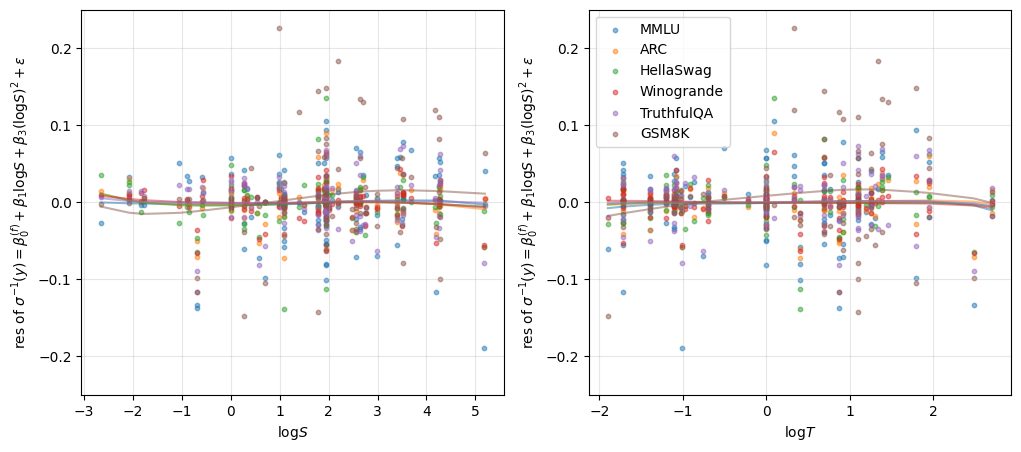

MMLU 0.04452326327821278
ARC 0.017601062179994846
HellaSwag 0.023640036767903674
Winogrande 0.017711394421864066
TruthfulQA 0.029019319100516652
GSM8K 0.035551151098313104


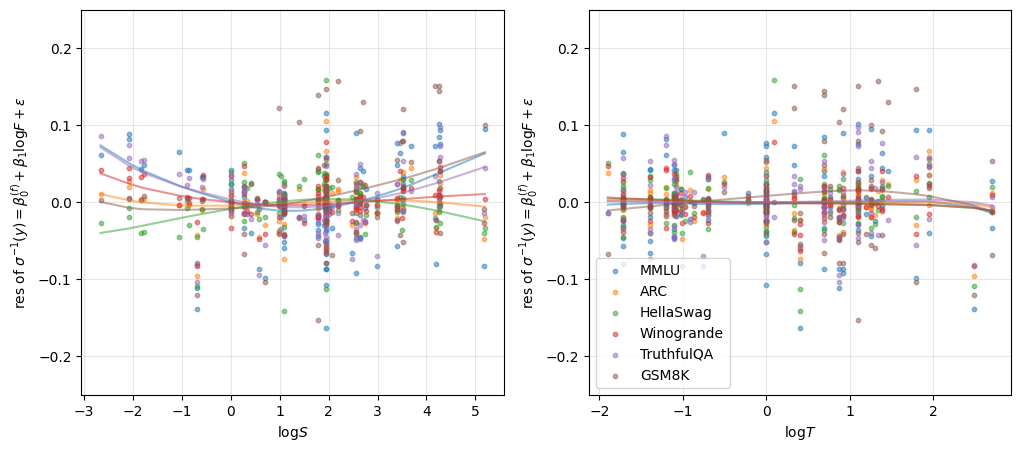

MMLU 0.07027034583757424
ARC 0.047309820441941465
HellaSwag 0.06105814008105574
Winogrande 0.04026262900980397
TruthfulQA 0.03510654831434281
GSM8K 0.08031054150174524


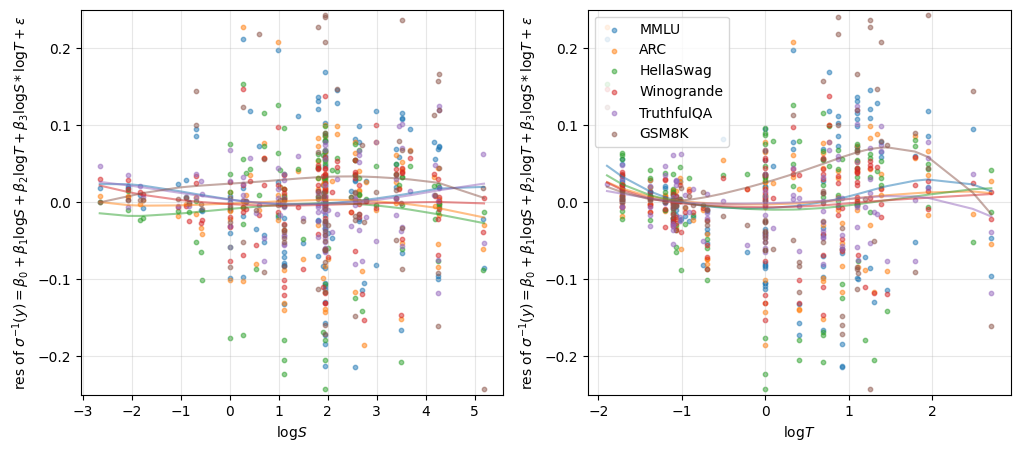

MMLU 0.025609506383354966
ARC 0.015030111131001705
HellaSwag 0.02175766694851414
Winogrande 0.012822778271153214
TruthfulQA 0.02148834251147685
GSM8K 0.033628694656050465


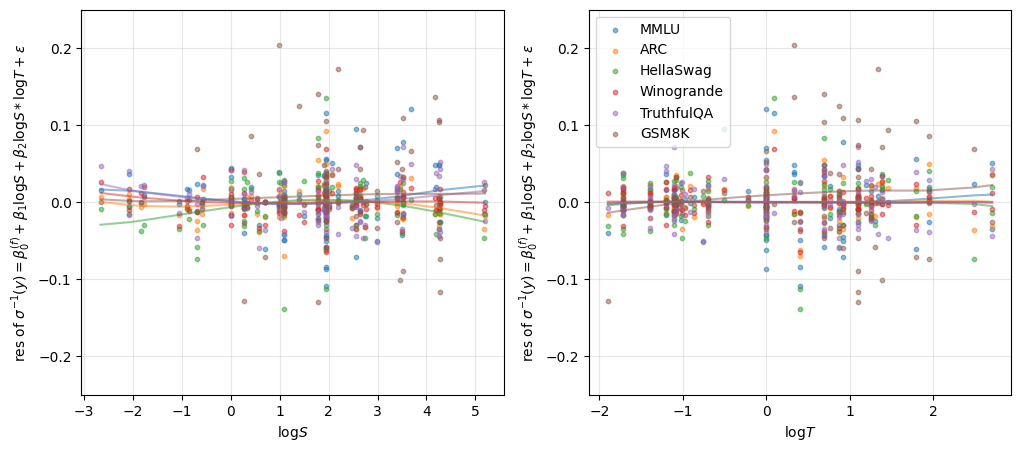

MMLU 0.02557949113405075
ARC 0.015052406197364195
HellaSwag 0.02165695414636186
Winogrande 0.012397293229584744
TruthfulQA 0.02154265205450043
GSM8K 0.03078197278073863


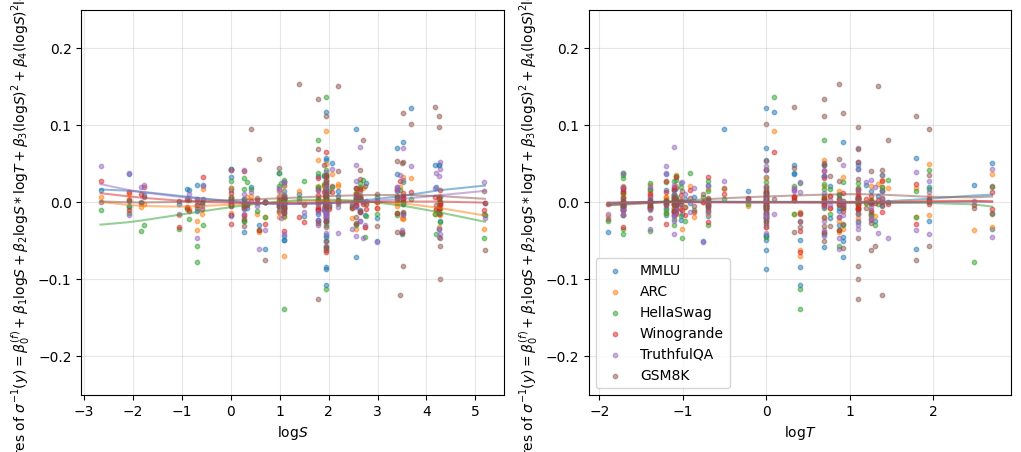

MMLU 0.02542459364565389
ARC 0.01368409478604037
HellaSwag 0.016613595380634116
Winogrande 0.012578231306085196
TruthfulQA 0.019364379949148802
GSM8K 0.032398139512019586


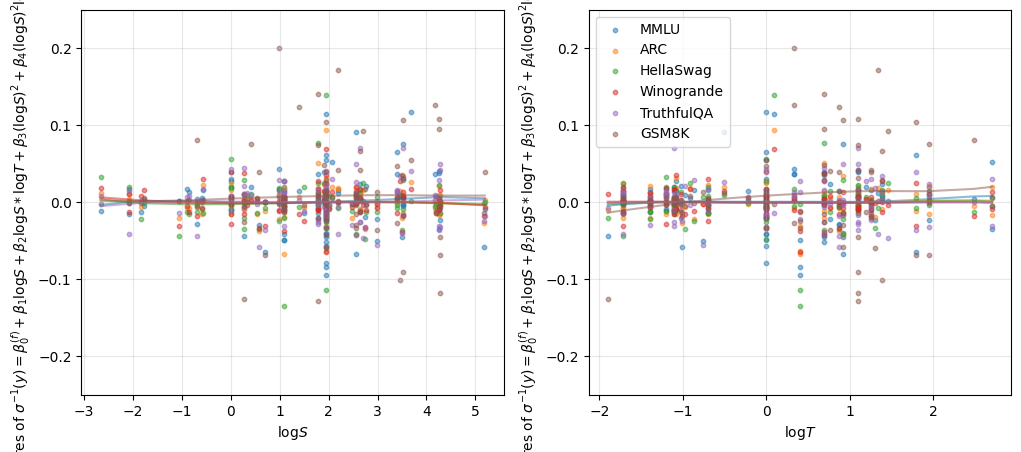

In [140]:
make_residual_plot(vars=['logS','logS**2'],
                   ylabel='res of $\\sigma^{-1}(y) = \\beta^{(f)}_0 + \\beta_1 \\text{log}S + \\beta_3 (\\text{log}S)^2 +\\varepsilon$',
                   family_intercept=True,
                   scenarios=scenarios)
plt.show()

make_residual_plot(vars=['logF'],
                   ylabel='res of $\\sigma^{-1}(y) = \\beta^{(f)}_0 + \\beta_1 \\text{log}F +\\varepsilon$',
                   family_intercept=True,
                   scenarios=scenarios)
#plt.savefig('fig21.png')
plt.show()
make_residual_plot(vars=['logT','logS','logT*logS'],
                   ylabel='res of $\\sigma^{-1}(y) = \\beta_0 + \\beta_1 \\text{log}S + \\beta_2 \\text{log}T + \\beta_3 \\text{log}S*\\text{log}T + \\varepsilon$',
                   family_intercept=False,
                   scenarios=scenarios)
#plt.savefig('fig22.png')
plt.show()
make_residual_plot(vars=['logS','logT*logS','logT*logS'],
                   ylabel='res of $\\sigma^{-1}(y) = \\beta^{(f)}_0 + \\beta_1 \\text{log}S + \\beta_2 \\text{log}S*\\text{log}T + \\varepsilon$',
                   family_intercept=True,
                   scenarios=scenarios)
#plt.savefig('fig23.png')
plt.show()
make_residual_plot(vars=['logS','logT','logT*logS'],
                   ylabel='res of $\\sigma^{-1}(y) = \\beta^{(f)}_0 + \\beta_1 \\text{log}S + \\beta_2 \\text{log}S*\\text{log}T + \\beta_3 (\\text{log}S)^2+ \\beta_4 (\\text{log}S)^2\\text{log}T+ \\varepsilon$',
                   family_intercept=True,
                   scenarios=scenarios)
#plt.savefig('fig24.png')
plt.show()
make_residual_plot(vars=['logS','logS**2','logT*logS**2','logT*logS'],
                   ylabel='res of $\\sigma^{-1}(y) = \\beta^{(f)}_0 + \\beta_1 \\text{log}S + \\beta_2 \\text{log}S*\\text{log}T + \\beta_3 (\\text{log}S)^2+ \\beta_4 (\\text{log}S)^2\\text{log}T+ \\varepsilon$',
                   family_intercept=True,
                   scenarios=scenarios)
#plt.savefig('fig24.png')
plt.show()

Nested model analysis

In [170]:
scenarios = ['IFEval','BBH','MATH Lvl 5','GPQA','MUSR','MMLU-PRO','MMLU','ARC','HellaSwag','Winogrande','TruthfulQA','GSM8K']

In [257]:
scenario = 'IFEval'

In [258]:
lower_bounds = {}
for s in scenarios:
    lower_bounds[s]=pd.read_csv('data/lower_bounds.csv')[s].iloc[0]
#lower_bounds

In [288]:
from statsmodels.othermod.betareg import BetaModel
from statsmodels.regression.linear_model import OLS

In [367]:
formulas_beta = ["Y ~ logF",
                 "Y ~ logF + Family - 1",
                 "Y ~ Family:logF",
                 #"Y ~ Family:logF+ Family - 1",###
                #
                 "Y ~ logS + logT",
                 "Y ~ logS + logT + logS:logT",
                 "Y ~ logS + logS:logT",
                 "Y ~ logS + logT + logS2 + logT2 + logS:logT",###
                
                 "Y ~ logS + logT + Family - 1",
                 "Y ~ logS + logS:logT + Family - 1",
                 "Y ~ logS + logT + logS:logT + Family - 1",
                 "Y ~ logS + logT + logS2 + logT2 + logS:logT + Family - 1"#,###

                #"Y ~ logS + logT + Instruct:logS + Instruct:logT + Family - 1",#
                #"Y ~ logS + logT + logS:logT + Instruct:logS + Instruct:logT + Instruct:logS:logT + Family - 1",#,
                #"Y ~ logS + logT + logS2 + logT2 + logS:logT + Instruct:logS + Instruct*logT + Instruct:logS2 + Instruct:logT2 + Instruct:logS:logT + Family - 1"###
                ]

formulas_gaussian = ["logitY ~ logF",
                     "logitY ~ logF + Family - 1",
                     "logitY ~ Family:logF",
                     #"logitY ~ Family:logF+ Family - 1",###
                    #
                     "logitY ~ logS + logT",
                     "logitY ~ logS + logS:logT",
                     "logitY ~ logS + logT + logS:logT",
                     "logitY ~ logS + logT + logS2 + logT2 + logS:logT",###
                    
                     "logitY ~ logS + logT + Family - 1",
                     "logitY ~ logS + logS:logT + Family - 1",
                     "logitY ~ logS + logT + logS:logT + Family - 1",
                     "logitY ~ logS + logT + logS2 + logT2 + logS:logT + Family - 1"#,###
    
                    #"logitY ~ logS + logT + Instruct:logS + Instruct:logT + Family - 1",#
                    #"logitY ~ logS + logT + logS:logT + Instruct:logS + Instruct:logT + Instruct:logS:logT + Family - 1",#,
                    #"logitY ~ logS + logT + logS2 + logT2 + logS:logT + Instruct:logS + Instruct*logT + Instruct:logS2 + Instruct:logT2 + Instruct:logS:logT + Family - 1"###
                ]

In [368]:
results_beta = []
results_gaussian = []

for scenario in tqdm(scenarios):
    data = pd.read_csv('data/data_v2.csv')
    data['logS'] = np.log(data['#Params (B)'])
    data['logT'] = np.log(data['Pretraining Data Size (T)'])
    data['logT*logS'] = data['logS']*data['logT']
    data['logS2'] = data['logS']**2
    data['logT2'] = data['logT']**2
    data['logF'] = np.log(data['FLOPs (1E21)'])
    data['logF2'] = data['logF']**2
    vars = ['logF', 'logS', 'logT', 'logF2', 'logS2', 'logT2']
    data['Family'] = data['Family2']
    data = data.loc[:, vars+[scenario, 'Family', 'Instruct']] #~data.Instruct
    data = data.dropna()
    eps = 1e-3
    data['Y'] = (data[scenario]-lower_bounds[scenario])/(1-lower_bounds[scenario])
    data.loc[data['Y']<=0,'Y'] = eps
    data['logitY'],_ = logit(data['Y'], eps=0, c=0)
    
    for formula in formulas_beta:
        model = BetaModel.from_formula(formula, data) #
        model = model.fit()
        aic, bic = model.aic, model.bic
        results_beta.append((scenario, formula, aic, bic))
        #print(model.summary())
    #results_df_beta = results_df_beta.sort_values(by=["AIC","BIC"])
    
    
    for formula in formulas_gaussian:
        model = OLS.from_formula(formula, data) #
        model = model.fit()
        aic, bic = model.aic, model.bic
        results_gaussian.append((scenario, formula, aic, bic))
        #print(model.summary())
    #results_df_gaussian = results_df_gaussian.sort_values(by=["AIC","BIC"])

results_df_beta = pd.DataFrame(results_beta, columns=["Scenario", "Formula", "AIC", "BIC"])
results_df_gaussian = pd.DataFrame(results_gaussian, columns=["Scenario", "Formula", "AIC", "BIC"])
results_df_beta['rank_AIC'] = results_df_beta.groupby('Scenario')['AIC'].rank()
results_df_beta['rank_BIC'] = results_df_beta.groupby('Scenario')['BIC'].rank()
results_df_gaussian['rank_AIC'] = results_df_gaussian.groupby('Scenario')['AIC'].rank()
results_df_gaussian['rank_BIC'] = results_df_gaussian.groupby('Scenario')['BIC'].rank()

  0%|          | 0/12 [00:00<?, ?it/s]

In [369]:
results_df_beta.groupby('Formula')['rank_AIC'].mean(),results_df_beta.groupby('Formula')['rank_BIC'].mean()

(Formula
 Y ~ Family:logF                                             5.166667
 Y ~ logF                                                    9.833333
 Y ~ logF + Family - 1                                       4.583333
 Y ~ logS + logS:logT                                        9.166667
 Y ~ logS + logS:logT + Family - 1                           2.416667
 Y ~ logS + logT                                             9.166667
 Y ~ logS + logT + Family - 1                                4.416667
 Y ~ logS + logT + logS2 + logT2 + logS:logT                 8.083333
 Y ~ logS + logT + logS2 + logT2 + logS:logT + Family - 1    1.916667
 Y ~ logS + logT + logS:logT                                 8.250000
 Y ~ logS + logT + logS:logT + Family - 1                    3.000000
 Name: rank_AIC, dtype: float64,
 Formula
 Y ~ Family:logF                                             9.166667
 Y ~ logF                                                    5.750000
 Y ~ logF + Family - 1                 

In [370]:
results_df_gaussian.groupby('Formula')['rank_AIC'].mean(),results_df_gaussian.groupby('Formula')['rank_BIC'].mean()

(Formula
 logitY ~ Family:logF                                             5.750000
 logitY ~ logF                                                    9.166667
 logitY ~ logF + Family - 1                                       5.083333
 logitY ~ logS + logS:logT                                        9.250000
 logitY ~ logS + logS:logT + Family - 1                           2.000000
 logitY ~ logS + logT                                             8.500000
 logitY ~ logS + logT + Family - 1                                4.666667
 logitY ~ logS + logT + logS2 + logT2 + logS:logT                 7.583333
 logitY ~ logS + logT + logS2 + logT2 + logS:logT + Family - 1    2.500000
 logitY ~ logS + logT + logS:logT                                 7.916667
 logitY ~ logS + logT + logS:logT + Family - 1                    3.583333
 Name: rank_AIC, dtype: float64,
 Formula
 logitY ~ Family:logF                                             10.166667
 logitY ~ logF                                  

Checking why IFEval, GSM8K, and MMLU do not fit well

In [408]:
scenario = 'IFEval'

formula = "Y ~ logS + logT + logS2 + logT2 + logS:logT + Family - 1"

In [409]:
data = pd.read_csv('data/data_v2.csv')
data['logS'] = np.log(data['#Params (B)'])
data['logT'] = np.log(data['Pretraining Data Size (T)'])
data['logT*logS'] = data['logS']*data['logT']
data['logS2'] = data['logS']**2
data['logT2'] = data['logT']**2
data['logF'] = np.log(data['FLOPs (1E21)'])
data['logF2'] = data['logF']**2
vars = ['logF', 'logS', 'logT', 'logF2', 'logS2', 'logT2']
data['Family'] = data['Family2']
data = data.loc[:, vars+[scenario, 'Family', 'Instruct']] #~data.Instruct
data = data.dropna()
eps = 1e-3
data['Y'] = (data[scenario]-lower_bounds[scenario])/(1-lower_bounds[scenario])
data.loc[data['Y']<=0,'Y'] = eps

model = BetaModel.from_formula(formula, data) #
model = model.fit()
print(model.summary())

                              BetaModel Results                               
Dep. Variable:                      Y   Log-Likelihood:                 202.19
Model:                      BetaModel   AIC:                            -308.4
Method:            Maximum Likelihood   BIC:                            -179.2
Date:                Tue, 03 Sep 2024                                         
Time:                        03:51:29                                         
No. Observations:                 109                                         
Df Residuals:                      61                                         
Df Model:                          46                                         
                                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------------
Family[bloom]                            -3.8275      0.512     -7.482      0

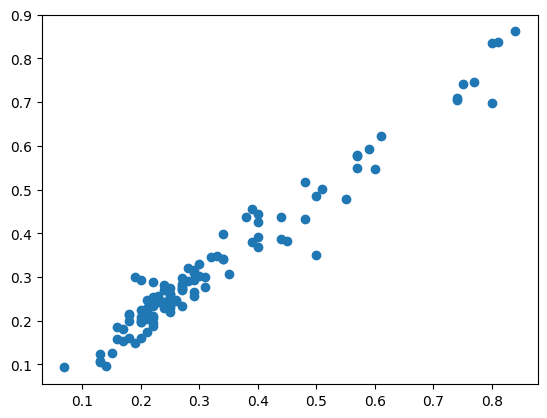

In [410]:
y = lower_bounds[scenario]+(1-lower_bounds[scenario])*np.array(data['Y'])
y_hat = lower_bounds[scenario]+(1-lower_bounds[scenario])*model.predict()
plt.scatter(y,y_hat)

In [411]:
np.abs((y-y_hat)).mean()

0.025661579354285716